# Dev info
- Feature: Use Numpy interpolation to fill the gaps
- Runs on: ReSurfEMG V1.1.1
- Methods: resurfemg.preprocessing.ecg_removal.gating

- Explanation: Gating method used a custom implementation for interpolation to
fill the gate windows. Using dedicated Numpy methods might speed-up to process
and make the function more transparent.

# 1. Import the required libraries

In [1]:
# Standard code libraries
import copy
import os
import time
import numpy as np
import pandas as pd
import scipy
from scipy.ndimage import median_filter
import neurokit2 as nk
import matplotlib.pyplot as plt


# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.converter_functions import load_file

from resurfemg.preprocessing import filtering as filt
from resurfemg.preprocessing import ecg_removal as ecg_rm
from resurfemg.preprocessing import envelope as evl

from resurfemg.postprocessing import baseline as bl
from resurfemg.postprocessing import event_detection as evt
from resurfemg.postprocessing import features as feat

config = Config(verbose=True)

%matplotlib widget

Loaded config from:
 C:\Users\WarnaarRSP/.resurfemg/config.json

The following paths were configured:
-------------------------------------------------------------------------------
 Name           	Path                                              
-------------------------------------------------------------------------------
 root           	C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\not_pushed
 output_data    	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg\not_pushed\output_data
 patient_data   	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW
 resurfemg_root 	P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie  
 preprocessed_data	C:\Users\WarnaarRSP\Repos\ReSurfEMG\resurfemg_addicht\not_pushed\preprocessed_data
 simulated_data 	C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\not_pushed\simulated_data
 test_data      	C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data
 vvuq_Grasshof  	C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\not_pushed\m3_stijn
 vvuq_ma

## 2. Load sEMG test data

# Load clean data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()
base_path = config.get_directory('vvuq_Grasshof')
# patient_paths = file_discovery.find_folders(
#     base_path,
#     folder_levels=['simulation', 'linear', 'run'])
# patient = list(patient_paths['simulation'].values)[0]

# Then find the files for the selected patients:
# folder_levels = ['date', 'measurement']
# patient_path = os.path.join(base_path, patient)

folder_levels_emg=['data', 'simulation', 'linear', 'run', 'sEMG']
emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*_dP1.00*',
    extension_regex='csv',
    folder_levels=folder_levels_emg, verbose=False)

folder_levels_vent=['data', 'simulation', 'linear', 'run']
vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*_dP1.00*',
    extension_regex='csv',
    folder_levels=folder_levels_vent, verbose=False)

button_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels_emg,
    default_value_select=None,
    default_idx_select=[0, 0, 0, 0, 1, 0])
button_list_vent = ipy_widgets.file_select(
    vent_files,
    folder_levels=folder_levels_vent,
    default_value_select=None,
    default_idx_select=[0, 0, 0, 1, 0])
emg_file_chosen = os.path.join(
    base_path, *[btn.value for btn in button_list_emg])
vent_file_chosen = os.path.join(
    base_path, *[btn.value for btn in button_list_vent])

print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

interactive(children=(Dropdown(description='data:', options=('Data',), value='Data'), Dropdown(description='si…

interactive(children=(Dropdown(description='data:', options=('Data',), value='Data'), Dropdown(description='si…

The chosen files are:
 C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\not_pushed\m3_stijn\Data\Simulation\Linear\Run_2\sEMG\EMG_EH_dP1.00_medAMP.csv 
 C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\not_pushed\m3_stijn\Data\Simulation\Linear\Run_2\Run2_EH_dP1.00.csv


In [3]:
# # Load the EMG from the selected folders (synthetic data):
# emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list])

# Load the EMG from the selected folders:
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list_emg])

# y_emg_clean, _, metadata_emg = load_file(emg_file_chosen)
# metadata_emg['fs'] = 2048
# metadata_emg['unit'] = ['uV', 'uV', 'uV']
# fs_emg = metadata_emg['fs']

# t_emg = [i/fs_emg for i in range(len(y_emg_clean[0, :]))]
vent_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list_vent])
# Load the Ventilator from the selected folders:
# y_vent, _, metadata_vent = load_file(vent_file_chosen)
# fs_vent = metadata_vent['fs']
# 
# y_vent = y_vent
# t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]


# Make noisy data

In [4]:
# Define VOGUE functions
def load_in_simulation(file_chosen):
    df_file = pd.read_csv(file_chosen, header=None)
    # Without interpolation
    Time_import = np.array(df_file.iloc[:, 0])
    Paw_import = np.array(df_file.iloc[:, 1])
    Flow_import = np.array(df_file.iloc[:, 2])
    Volume_import = np.array(df_file.iloc[:, 3])
    Pmus_import = np.array(df_file.iloc[:, 4])

    # Because time stepping is not equally spaced
    dt_sim = 0.001
    fs_sim = 1 / dt_sim
    Time_sim = np.arange(Time_import[0], Time_import[-1] + dt_sim, dt_sim)
    Paw_sim = np.interp(Time_sim, Time_import, Paw_import)
    Flow_sim = np.interp(Time_sim, Time_import, Flow_import)
    Volume_sim = np.interp(Time_sim, Time_import, Volume_import)
    Pmus_sim = np.interp(Time_sim, Time_import, Pmus_import)

    return Time_sim, Paw_sim, Flow_sim, Volume_sim, Pmus_sim, fs_sim

def sEMG_generator(
    time,
    emg,
    hr,
    fs,
    noise_level,
    NMC_sim,
    drift_amp=20,
    ecg_amp=200,
):
    np.random.seed(42)
    
    # NMC
    EMG_nmc = emg / NMC_sim
    
    mean = 0
    std = 1
    white_noise = np.random.normal(mean, std, size=len(time))

    # Time varying baseline
    # Random noise lowpass filter 1 Hz
    sos_baseline = scipy.signal.butter(2, 1, fs=fs, btype="low", output="sos")
    wn_baseline = scipy.signal.sosfilt(sos_baseline, white_noise, axis=0)

    drift_emg = 7 + drift_amp * wn_baseline + 0.5 * np.sin(0.05 * np.pi * time)
    sEMG_drift = EMG_nmc + drift_emg

    # Check heart rate
    # ECG simulating
    time_duration = int(2 * (time[-1] - time[0]))
    length_ecg = int(len(time))
    ecg_simulated = nk.ecg_simulate(
        duration=time_duration,
        length=length_ecg,
        noise=0,
        sampling_rate=int(fs / 2),
        heart_rate=int(hr / 2),
        random_state=11,
    )
    ecg = ecg_simulated * ecg_amp  # To increase amplitude
    peaks = scipy.signal.find_peaks(ecg_simulated, height=0.4, prominence=1)[0]
    t_peaks = time[peaks]
    diff_peaks = np.diff(t_peaks)
    hr_new = 60 / diff_peaks
    print(f"HR is: {np.mean(hr_new)}")

    # Make equal length
    sEMG_ECG = sEMG_drift + ecg

    # Add noise
    noise = noise_level * np.random.normal(0, 1, len(time))
    sEMG_raw = sEMG_ECG + noise
    print("Done: sEMG template created!")

    # ecg= np.zeros_like(pmus)
    return sEMG_raw, ecg, EMG_nmc

In [5]:
hr = 80
NMC_sim = 3.0  # updated
noise_level = 1.0 #
fs_emg = 2048
fs_vent = 100

# Load the simulation data
(Time_sim, Paw_sim, Flow_sim, Volume_sim, Pmus_sim, fs_sim) = (
    load_in_simulation(vent_file_chosen)
)

df_EMG = pd.read_csv(emg_file_chosen)
t_emg_sim = df_EMG["Time"].to_numpy()
EMGdi_sim = df_EMG["EMGdi"].to_numpy()
EMGpara_sim = df_EMG["EMGpara"].to_numpy()
# Interpolate the simulation data
T = 600
t_emg = np.arange(0, T + 1 / fs_emg, 1 / fs_emg)
t_vent = np.arange(0, T + 1 / fs_vent, 1 / fs_vent)

Paw = np.interp(t_vent, Time_sim, Paw_sim)
Flow = np.interp(t_vent, Time_sim, Flow_sim)
Volume = np.interp(t_vent, Time_sim, Volume_sim)
Pmus = np.interp(t_emg, Time_sim, Pmus_sim)
EMGdi = np.interp(t_emg, t_emg_sim, EMGdi_sim)
EMGpara = np.interp(t_emg, t_emg_sim, EMGpara_sim)

Pmus = Pmus * -1  # Definition

y_emg_clean = np.array([EMGdi, EMGpara])

# Create sEMG
(sEMGdi, ecg, emgdi) = sEMG_generator(
    t_emg, EMGdi, hr, fs_emg, noise_level, NMC_sim
)

(sEMGpara, ecg, emgpara) = sEMG_generator(
    t_emg, EMGpara, hr, fs_emg, noise_level, NMC_sim
)

y_emg_noise = np.array([ecg, sEMGdi, sEMGpara])
y_vent = np.array([Paw, Flow, Volume])

HR is: 79.38318327748307
Done: sEMG template created!
HR is: 79.38318327748307
Done: sEMG template created!


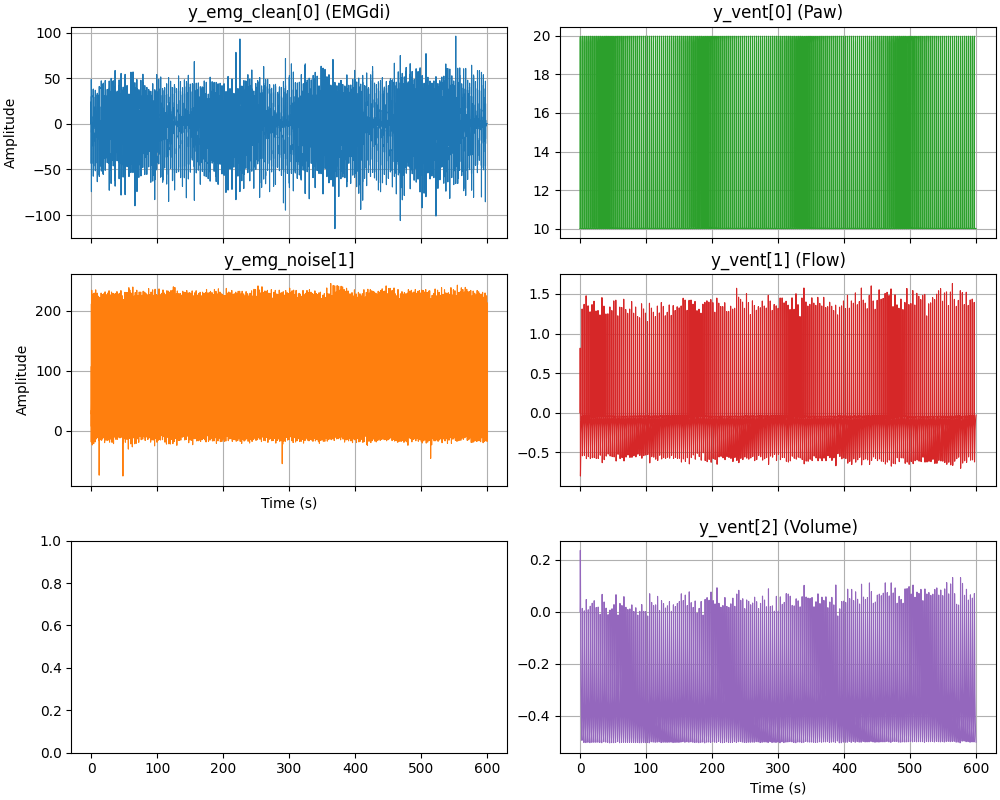

In [6]:
# Plot EMG (left column) and ventilator channels (right column)
fig, axes = plt.subplots(3, 2, figsize=(10, 8), constrained_layout=True, sharex=True)
ax_emg1 = axes[0, 0]
ax_emg2 = axes[1, 0]
ax_v0 = axes[0, 1]
ax_v1 = axes[1, 1]
ax_v2 = axes[2, 1]

# First channel of y_emg_clean
ax_emg1.plot(t_emg, y_emg_clean[0, :], color='tab:blue', lw=0.8)
ax_emg1.set_ylabel('Amplitude')
ax_emg1.set_title('y_emg_clean[0] (EMGdi)')
ax_emg1.grid(True)

# Second channel of y_emg_noise
ax_emg2.plot(t_emg, y_emg_noise[1, :], color='tab:orange', lw=0.8)
ax_emg2.set_ylabel('Amplitude')
ax_emg2.set_title('y_emg_noise[1]')
ax_emg2.set_xlabel('Time (s)')
ax_emg2.grid(True)

# Three channels of y_vent
ax_v0.plot(t_vent, y_vent[0, :], color='tab:green', lw=0.8)
ax_v0.set_title('y_vent[0] (Paw)')
ax_v0.grid(True)

ax_v1.plot(t_vent, y_vent[1, :], color='tab:red', lw=0.8)
ax_v1.set_title('y_vent[1] (Flow)')
ax_v1.grid(True)

ax_v2.plot(t_vent, y_vent[2, :], color='tab:purple', lw=0.8)
ax_v2.set_title('y_vent[2] (Volume)')
ax_v2.set_xlabel('Time (s)')
ax_v2.grid(True)

plt.show()

# 3. Pre-process the data

In [7]:
# Gating for comparison
y_emg_clean_filt = filt.emg_bandpass_butter(
    y_emg_clean,
    fs_emg=fs_emg,
    high_pass=20,
    low_pass=500,
    order=4,
)

y_emg_noise_filt = filt.emg_bandpass_butter(
    y_emg_noise,
    fs_emg=fs_emg,
    high_pass=20,
    low_pass=500,
    order=4,
)


# 4. Apply gating to new signals

In [8]:
def gating_new(
    emg_raw,
    peak_idxs,
    gate_width=205,
    method=1,
    **kwargs
):
    """
    Eliminate peaks (e.g. QRS) from emg_raw using gates
    of width gate_width. The gate either filled by zeros or interpolation.
    The filling method for the gate is encoded as follows:
    0: Filled with zeros
    1: Interpolation samples before and after
    2: Fill with average of prior segment if exists
    otherwise fill with post segment
    3: Fill with running average of RMS (default)
    ---------------------------------------------------------------------------
    :param emg_raw: Signal to process
    :type emg_raw: ~numpy.ndarray
    :param peak_idxs: list of individual peak index places to be gated
    :type peak_idxs: ~list
    :param gate_width: width of the gate
    :type gate_width: int
    :param method: filling method of gate
    :type method: int

    :returns emg_raw_gated: the gated result
    :rtype emg_raw_gated: numpy.ndarray
    """
    emg_raw_gated = copy.deepcopy(emg_raw)
    max_sample = emg_raw_gated.shape[0]
    half_gate_width = gate_width // 2
    if method == 0:
        # Method 0: Fill with zeros
        # Vectorized construction of gate sample indices
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size == 0:
            gate_samples = np.array([], dtype=int)
        else:
            starts = np.maximum(0, peaks - half_gate_width)
            ends = np.minimum(max_sample, peaks + half_gate_width)
            # build ranges per peak and concat, then unique to avoid duplicates
            gate_samples = np.concatenate(
                [np.arange(s, e) for s, e in zip(starts, ends)])
            gate_samples = np.unique(gate_samples).astype(int)

        emg_raw_gated[gate_samples] = 0
    elif method == 1:
        # Method 1: Fill with interpolation pre- and post gate sample
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            max_sample = emg_raw_gated.shape[0]
            for peak in peaks:
                pre_idx = peak - half_gate_width - 1
                pre_val = emg_raw[pre_idx] if (
                    pre_idx >= 0 and pre_idx < max_sample) else 0

                post_idx = peak + half_gate_width + 1
                post_val = emg_raw[post_idx] if (
                    post_idx >= 0 and post_idx < max_sample) else 0

                k_start = max(0, peak - half_gate_width)
                k_end = min(peak + half_gate_width, max_sample)
                if k_start >= k_end:
                    continue

                ks = np.arange(k_start, k_end)
                frac = (ks - peak + half_gate_width) / float(gate_width)
                emg_raw_gated[ks] = (1.0 - frac) * pre_val + frac * post_val

    elif method == 2:
        # Method 2: Fill with window length mean over prior section
        # ..._____|_______|_______|XXXXXXX|XXXXXXX|_____...
        #         ^               ^- gate start   ^- gate end
        #         - peak - half_gate_width * 3 (replacer)

        for _, peak in enumerate(peak_idxs):
            start = peak - half_gate_width * 3
            if start < 0:
                start = peak + half_gate_width
            end = start + gate_width
            pre_ave_emg = np.nanmean(emg_raw[start:end])

            k_start = max(0, peak - half_gate_width)
            k_end = min(peak + half_gate_width, emg_raw_gated.shape[0])
            for k in range(k_start, k_end):
                emg_raw_gated[k] = pre_ave_emg

    elif method == 3:
        # Method 3: Fill with moving average over RMS
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            # Build boolean mask of gate samples
            gate_mask = np.zeros(max_sample, dtype=bool)
            half_w = gate_width / 2
            starts = np.maximum(0, (peaks - half_w).astype(int))
            ends = np.minimum(max_sample, (peaks + half_w).astype(int))
            for s, e in zip(starts, ends):
                if s < e:
                    gate_mask[s:e] = True            

            # Compute RMS with gated samples as NaN
            emg_raw_gated_base = emg_raw_gated.copy()
            emg_raw_gated_base[gate_mask] = np.nan
            emg_raw_gated_rms = evl.full_rolling_rms(
                emg_raw_gated_base, gate_width)

            # Compute local mean of the RMS over a window of ~3*gate_widths
            w = max(1, 2 * int(1.5 * gate_width) + 1)
            if gate_width % 2 == 0:
                closed = "neither"
            else:
                closed = "left"
            local_mean = pd.Series(emg_raw_gated_rms).rolling(
                window=w,
                min_periods=1,
                center=True,
                closed=closed).mean().values

            # Assign local_mean where available within gates
            mask_available = gate_mask & (~np.isnan(local_mean))
            emg_raw_gated[mask_available] = local_mean[mask_available]

            # Remaining gate samples to interpolate
            interp_mask = gate_mask & np.isnan(local_mean)
            # # TODO: Interpolation is combined below for methods 3 and 4
            # if np.any(interp_mask):'
            #     interp_idx = np.nonzero(interp_mask)[0]
            #     other_idx = np.nonzero(~interp_mask)[0]

            #     # Boundary handling: Set endpoints to 0 if part of interp_idx
            #     if 0 in interp_idx:
            #         emg_raw_gated[0] = 0.0
            #         interp_mask[0] = False
            #     if (max_sample - 1) in interp_idx:
            #         emg_raw_gated[-1] = 0.0
            #         interp_mask[-1] = False

            #     interp_idx = np.nonzero(interp_mask)[0]
            #     other_idx = np.nonzero(~interp_mask)[0]

            #     if other_idx.size > 0 and interp_idx.size > 0:
            #         # Ensure there are values to interpolate from
            #         emg_raw_gated_interp = np.interp(
            #             interp_idx,
            #             other_idx,
            #             emg_raw_gated[other_idx]
            #         )
            #         emg_raw_gated[interp_idx] = emg_raw_gated_interp
    elif method == 4:
        # Method 4: Fill with quadratic fit to RMS 
        peaks = np.asarray(peak_idxs, dtype=int).ravel()
        if peaks.size > 0:
            # Build boolean mask of gate samples
            gate_mask = np.zeros(max_sample, dtype=bool)
            half_w = gate_width / 2
            starts = np.maximum(0, (peaks - half_w).astype(int))
            ends = np.minimum(max_sample, (peaks + half_w).astype(int))
            for s, e in zip(starts, ends):
                if s < e:
                    gate_mask[s:e] = True

            # Compute RMS with gated samples as NaN
            emg_raw_gated_base = emg_raw_gated.copy()
            emg_raw_gated_base[gate_mask] = np.nan
            emg_raw_gated_rms = evl.full_rolling_rms(
                emg_raw_gated_base, gate_width)
            emg_raw_gated[gate_mask] = np.nan

            # Fit a local cubic (or lower-degree if needed) to RMS using
            local_mean = np.full(max_sample, np.nan)
            # identify contiguous gated segments
            gated_idx = np.nonzero(gate_mask)[0]
            if gated_idx.size > 0:
                # find breaks in the gated indices to get segments
                breaks = np.where(np.diff(gated_idx) != 1)[0]
                seg_starts = gated_idx[np.concatenate(([0], breaks + 1))]
                seg_ends = gated_idx[np.concatenate((
                    breaks, [gated_idx.size - 1]))]
                
                poly_width = kwargs.get('poly_width', 5 * gate_width)

                for gs, ge in zip(seg_starts, seg_ends):
                    pre_s = max(0, gs - poly_width // 2)
                    post_e = min(max_sample, ge + 1 + poly_width // 2)

                    # support indices and values from RMS (skip NaNs)
                    idx_pre = np.arange(pre_s, gs)
                    idx_post = np.arange(ge + 1, post_e)
                    support_idx = np.concatenate((idx_pre, idx_post))
                    support_vals = emg_raw_gated_rms[support_idx]
                    valid_mask = ~np.isnan(support_vals)
                    valid_idx = support_idx[valid_mask]
                    valid_vals = support_vals[valid_mask]

                    # fit polynomial to valid RMS support
                    fit_available = valid_idx.size >= 2
                    if fit_available:
                        deg = min(2, valid_idx.size - 1)
                        p_seg = np.polyfit(
                            valid_idx, valid_vals, deg)
                        ks = np.arange(gs, ge + 1)
                        emg_raw_gated[gs:ge + 1] = np.polyval(p_seg, ks)
            interp_mask = gate_mask & np.isnan(emg_raw_gated)
    if method in [3, 4]:
        if np.any(interp_mask):
            interp_idx = np.nonzero(interp_mask)[0]
            other_idx = np.nonzero(~interp_mask)[0]

            # Boundary handling: Set endpoints to 0 if part of interp_idx
            if 0 in interp_idx:
                emg_raw_gated[0] = 0.0
                interp_mask[0] = False
            if (max_sample - 1) in interp_idx:
                emg_raw_gated[-1] = 0.0
                interp_mask[-1] = False

            interp_idx = np.nonzero(interp_mask)[0]
            other_idx = np.nonzero(~interp_mask)[0]

            if other_idx.size > 0 and interp_idx.size > 0:
                # Ensure there are values to interpolate from
                emg_raw_gated_interp = np.interp(
                    interp_idx,
                    other_idx,
                    emg_raw_gated[other_idx]
                )
                emg_raw_gated[interp_idx] = emg_raw_gated_interp
 

    return emg_raw_gated

In [9]:
# Detect ECG peaks
ecg_peaks_idxs = ecg_rm.detect_ecg_peaks(
    ecg_raw=y_emg_noise[0, :],
    fs=fs_emg)

In [10]:
# Method 3: Fill with running average of RMS (default)
emg_noise_gated_m3 = gating_new(
    emg_raw=y_emg_noise_filt[1, :],
    peak_idxs=ecg_peaks_idxs,
    gate_width=205,
    method=3,
)
# Method 4: Fill with quadratic fit to RMS
emg_noise_gated_m4 = gating_new(
    emg_raw=y_emg_noise_filt[1, :],
    peak_idxs=ecg_peaks_idxs,
    gate_width=205,
    method=4,
)



In [11]:
# Calculate envelopes of signals
emg_clean_env = evl.full_rolling_rms(
    y_emg_clean_filt[0, :], window_length=205)
emg_noise_gated_m3_env = evl.full_rolling_rms(
    emg_noise_gated_m3, window_length=205)
emg_noise_gated_m4_env = evl.full_rolling_rms(
    emg_noise_gated_m4, window_length=205)


In [12]:
# Calculate moving baselines
baseline_clean = bl.moving_baseline(
    emg_clean_env, window_s=7.5*fs_emg, step_s=fs_emg // 5)
baseline_m3 = bl.moving_baseline(
    emg_noise_gated_m3_env, window_s=7.5*fs_emg, step_s=fs_emg // 5)
baseline_m4 = bl.moving_baseline(
    emg_noise_gated_m4_env, window_s=7.5*fs_emg, step_s=fs_emg // 5)

In [13]:
# Detect sEAdi peaks and on/offsets
seadi_peak_clean = evt.detect_emg_breaths(
    emg_env=emg_clean_env, emg_baseline=baseline_clean)
clean_start_idxs, clean_end_idxs, _, _, clean_valid_peaks = evt.onoffpeak_baseline_crossing(
    signal_env=emg_clean_env, baseline=baseline_clean,
    peak_idxs=seadi_peak_clean)

seadi_peak_m3 = evt.detect_emg_breaths(
    emg_env=emg_noise_gated_m3_env, emg_baseline=baseline_m3)
m3_start_idxs, m3_end_idxs, _, _, m3_valid_peaks = evt.onoffpeak_baseline_crossing(
    signal_env=emg_noise_gated_m3_env, baseline=baseline_m3,
    peak_idxs=seadi_peak_m3)

seadi_peak_m4 = evt.detect_emg_breaths(
    emg_env=emg_noise_gated_m4_env, emg_baseline=baseline_m4)
m4_start_idxs, m4_end_idxs, _, _, m4_valid_peaks = evt.onoffpeak_baseline_crossing(
    signal_env=emg_noise_gated_m4_env, baseline=baseline_m4,
    peak_idxs=seadi_peak_m4)

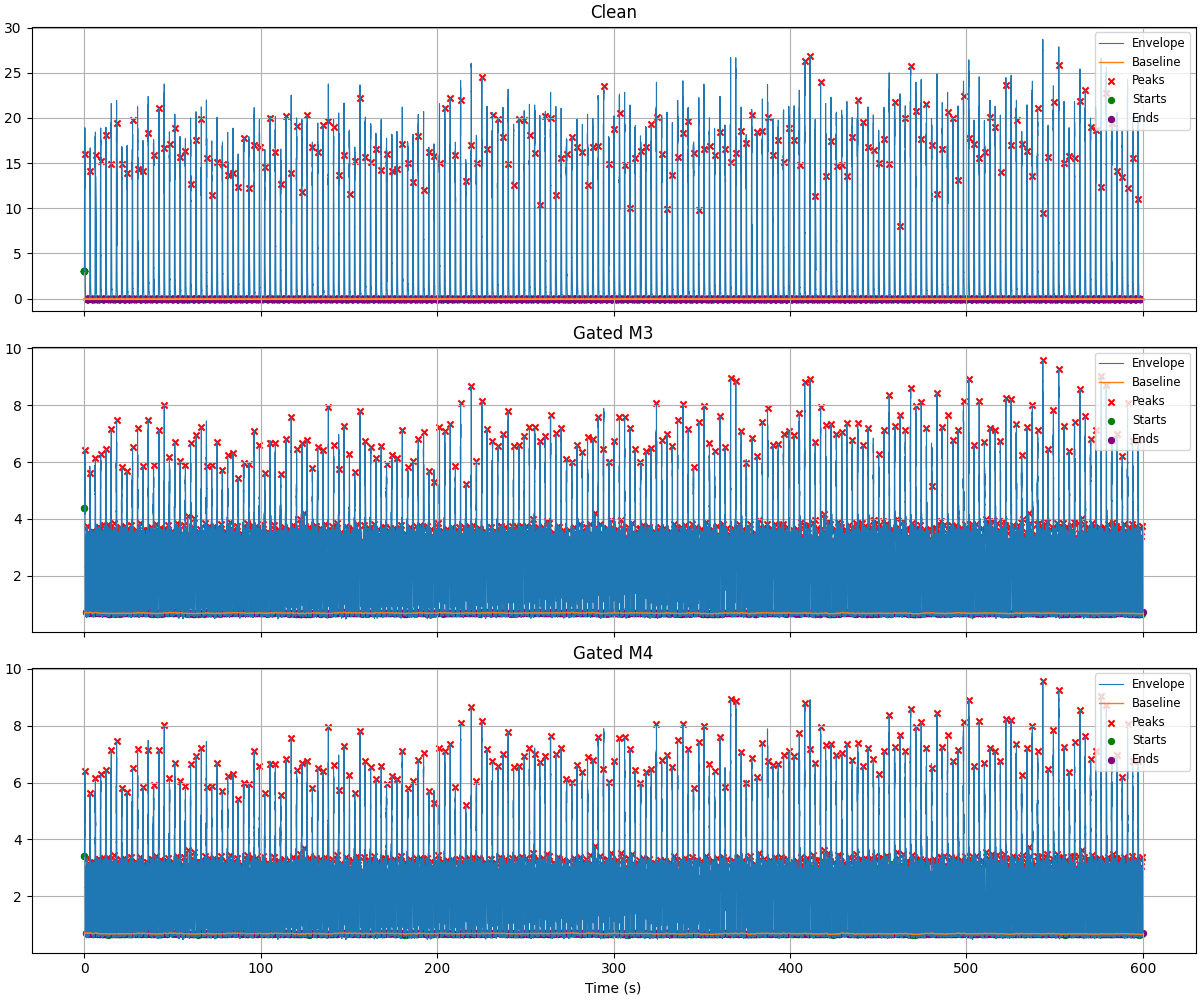

In [14]:
# Plot envelopes, baselines, peaks, start and end indices in 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True, constrained_layout=True)

plots = [
    ("Clean", emg_clean_env, baseline_clean, seadi_peak_clean, clean_start_idxs, clean_end_idxs, clean_valid_peaks),
    ("Gated M3", emg_noise_gated_m3_env, baseline_m3, seadi_peak_m3, m3_start_idxs, m3_end_idxs, m3_valid_peaks),
    ("Gated M4", emg_noise_gated_m4_env, baseline_m4, seadi_peak_m4, m4_start_idxs, m4_end_idxs, m4_valid_peaks),
]

for ax, (title, env, baseline, peaks, starts, ends, valid_peaks) in zip(axes, plots):
    ax.plot(t_emg, env, color="tab:blue", lw=0.8, label="Envelope")
    ax.plot(t_emg, baseline, color="tab:orange", lw=1.0, label="Baseline")
    ax.set_title(title)
    ax.grid(True)

    # peaks (only those marked valid)
    try:
        valid_mask = np.asarray(valid_peaks, dtype=bool)
        peak_idxs_valid = np.asarray(peaks)[valid_mask]
    except Exception:
        # if no valid_peaks or mismatch, fall back to all peaks
        peak_idxs_valid = np.asarray(peaks)

    peak_idxs_valid = peak_idxs_valid[(peak_idxs_valid >= 0) & (peak_idxs_valid < len(t_emg))]
    if peak_idxs_valid.size > 0:
        ax.scatter(t_emg[peak_idxs_valid], env[peak_idxs_valid], c="red", s=20, marker="x", label="Peaks")

    # starts and ends (ensure indices are in-range)
    starts = np.asarray(starts, dtype=int)
    ends = np.asarray(ends, dtype=int)
    starts = starts[(starts >= 0) & (starts < len(t_emg))]
    ends = ends[(ends >= 0) & (ends < len(t_emg))]

    if starts.size > 0:
        ax.scatter(t_emg[starts], env[starts], c="green", s=18, marker="o", label="Starts")
    if ends.size > 0:
        ax.scatter(t_emg[ends], env[ends], c="purple", s=18, marker="o", label="Ends")

    ax.legend(loc="upper right", fontsize="small")

axes[-1].set_xlabel("Time (s)")
plt.show()